In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Custom tools
from X_ranking import *
from priority_tools import *

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
rcParams["font.family"] = "serif"
rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{bm} \usepackage{physics}']
%config InlineBackend.figure_format = 'retina' # For high quality figures

In [3]:
# Read in TOIs perfect csv file
tois_perfect_df_path = 'data/TKS/tks_output/TOIs_perfect_final.csv'
tois_perfect_df = pd.read_csv(tois_perfect_df_path)

# Add relevant columns for the SC3 algorithm
tois_perfect_df['TSM'] = get_TSM(tois_perfect_df['rp'], 
                                 tois_perfect_df['rs'], 
                                 tois_perfect_df['teff'], 
                                 tois_perfect_df['jmag'], 
                                 tois_perfect_df['mp'], 
                                 tois_perfect_df['a_to_R'])
tois_perfect_df['t_HIRES'] = t_HIRES_plavchan(tois_perfect_df['vmag'], 250, tois_perfect_df['k'])
tois_perfect_df['X'] = tois_perfect_df['TSM'] / tois_perfect_df['t_HIRES']

# Get all targets rows that were picked by a science case
picked_query_string = ''
science_cases = ['other_programs', 
                 'SC1A', 'SC1B', 'SC1C', 'SC1D', 'SC1E', 
                 'SC2A', 'SC2Bi', 'SC2Bii', 'SC2C', 
                 'SC3', 
                 'SC4', 
                 'TOA', 'TOB']
picked_query_string += 'in_other_programs == 1 or '
for i in range(1, len(science_cases) - 1):
    picked_query_string += f'in_{science_cases[i]} == 1 or '
picked_query_string += 'in_TOB == 1'
tois_picked_df = tois_perfect_df.query(picked_query_string)

# Get all rows that were picked by SC3
sc3_picks_df = tois_perfect_df[tois_perfect_df['in_SC3'] == 1]

In [16]:
print(f"Number of target planets to choose from: {len(tois_perfect_df):4}")
print(f"Number of target systems to choose from: {len(tois_perfect_df.drop_duplicates(subset='tic')):4}")
print("------------------------")
print(f"Number of target planets in full sample: {len(tois_picked_df):4}")
print(f"Number of target systems in full sample: {len(tois_picked_df.drop_duplicates(subset='tic')):4}")
print("------------------------")
print(f"Numer of SC3 target planets: {len(sc3_picks_df):5}")
print(f"Numer of SC3 target systems: {len(sc3_picks_df.drop_duplicates(subset='tic')):5}")

Number of target planets to choose from:  622
Number of target systems to choose from:  595
------------------------
Number of target planets in full sample:  108
Number of target systems in full sample:   93
------------------------
Numer of SC3 target planets:    53
Numer of SC3 target systems:    42


In [31]:
def sc3_summary_plot(sc3_df, sample_df, 
                     hist_bin_num=20, 
                     annotate=True, 
                     annotate_up_to=6):
    '''
    Create a summary plot of where the ranked targets in sc3_df fall in V magnitude,
    K-amplitude, planet radius, and priority. Optionally include the IDs of systems
    that are benchmarks for reference.

    Args
    ----------
    sc3_df (DataFrame): A subset of the rows from TOIs perfect with the SC3 program's picks
    sample_df (DataFrame): Rows from TOIs perfect that were picked by any program
    hist_bin_num (optional, int, default = 10): The number of bins to use for the histograms.
    annotate (optional, bool, default = True): Annotate SC3 picks with TOI number if True.
    
    Returns
    ----------
    figure: A matplotlib figure containing the summary plot.
    axes: An array of the figure's subplot axes.
    '''
    fig, axes = plt.subplots(figsize=(18,10), ncols=3, nrows=2, sharey='row', sharex='col')
    ax_vmag, ax_kamp, ax_rad, ax_p_vmag, ax_p_kamp, ax_p_rad = axes.flatten()

    # Map priority level to a color
    colors = plt.cm.viridis(np.linspace(0., 1, 6))
    
    # Plot data in top row panels
    top_row_axes = [ax_vmag, ax_kamp, ax_rad]
    x_axis_keys = ['vmag', 'k', 'rp']
    for ax, x_axis_key in zip(top_row_axes, x_axis_keys):
        
        for index, row in sc3_df.iterrows():
            priority = None
            try:
                priority = int(row['SC3_bin_rank'])
            except:
                priority = 6 # If unranked by SC3 bin priority
            color = colors[priority - 1]

            ax.plot(row[x_axis_key], row['X'], '.', alpha=0.7, color=color)
            
            if annotate:
                if priority in np.arange(1, annotate_up_to + 1):
                    ax.annotate(str(row['toi']),
                                (row[x_axis_key], row['X']),
                                 textcoords='offset points',
                                 xytext=(-5,5),
                                 ha='left',
                                 clip_on=True)
        
        # Make this call just to get a label (place it underneath everything so you (hopefully) can't see it)
        ax.plot(row[x_axis_key], np.nan, 
                '.', 
                alpha=0.7,
                color='k',
                label='Picked by SC3', 
                zorder=0)
        
        not_sc3 = sample_df[sample_df['in_SC3'] != 1]
        ax.plot(not_sc3[x_axis_key], not_sc3['X'], 
                '.', 
                marker='^', 
                alpha=0.3, 
                color='gray', 
                label='Picked by other program', 
                zorder=0)
    
    # Set the axis labels for the top row
    vmag_low, vmag_high = ax_vmag.get_xlim()
    ax_vmag.set_xlim([vmag_high, vmag_low]) # Invert x axis for V mag panel
    ax_vmag.set_xlabel('$V$ [mag]', fontsize=14)
    ax_kamp.set_xlabel('$K$ [m s$^{-1}$]', fontsize=14)
    ax_rad.set_xlabel(r'$R$ [$R_\oplus$]', fontsize=14)
    
    # Add legend for top row
    ax_vmag.legend(fancybox=True, fontsize=12, loc='upper left')
    
    # Plot histograms in the bottom row
    # ------------------------------------
    # Histogram formatting styles for targets with different SC3 bin rankings
    sc3_bin_rank_str = "SC3 bin rank: "
    hist_styles = {
        1:{
            'histtype':'stepfilled',
            'alpha':0.5,
            'linestyle':'-',
            'hatch':None,
            'label':sc3_bin_rank_str + '1',
            'color':colors[0]
        },
        2:{
            'histtype':'stepfilled',
            'alpha':0.5,
            'linestyle':'-',
            'hatch':None,
            'label':sc3_bin_rank_str + '2',
            'color':colors[1]
        },
        3:{
            'histtype':'stepfilled',
            'alpha':0.5,
            'linestyle':'-',
            'hatch':None,
            'label':sc3_bin_rank_str + '3',
            'color':colors[2]
        },
        4:{
            'histtype':'step',
            'alpha':1.,
            'linestyle':'-',
            'hatch':'+',
            'label':sc3_bin_rank_str + '4',
            'color':colors[3]
        },
        5:{
            'histtype':'step',
            'alpha':1.,
            'linestyle':'-',
            'hatch':'/',
            'label':sc3_bin_rank_str + '5',
            'color':colors[4]
        },
        6:{
            'histtype':'step',
            'alpha':1.,
            'linestyle':'-',
            'hatch':'x',
            'label':'SC3 unranked',
            'color':colors[-1]
        }
    }
    
    hist_axes = [ax_p_vmag, ax_p_kamp, ax_p_rad]
    for ax, x_axis_key in zip(hist_axes, x_axis_keys):
        
        # Set bins by hand depending on the x-axis
        bins = None
        if x_axis_key == 'vmag':
            bins = np.linspace(sample_df[x_axis_key].min(), 
                               sample_df[x_axis_key].max(), 
                               hist_bin_num)
        elif x_axis_key == 'k':
            bins = np.logspace(np.log10(sample_df[x_axis_key].min()), 
                               np.log10(sample_df[x_axis_key].max()), 
                               hist_bin_num)
        elif x_axis_key == 'rp':
            bins = np.logspace(0, 
                               np.log10(sample_df[x_axis_key].max()), 
                               hist_bin_num)
        
        # Plot the targets with an SC3 bin ranking
        for i in range(1, 6):
            hist_style = hist_styles[i]
            
            ax.hist(sc3_df[sc3_df['SC3_bin_rank'] == i][x_axis_key].dropna().values, 
                    bins=bins, 
                    histtype=hist_style['histtype'], 
                    alpha=hist_style['alpha'], 
                    color=hist_style['color'], 
                    linestyle=hist_style['linestyle'], 
                    hatch=hist_style['hatch'], 
                    label=hist_style['label'])
            
        # Plot the targets without an SC3 bin ranking
        hist_style = hist_styles[6]
        ax.hist(sc3_df[pd.isnull(sc3_df['SC3_bin_rank'])][x_axis_key].values,
                bins=bins, 
                histtype=hist_style['histtype'], 
                alpha=hist_style['alpha'], 
                color=hist_style['color'], 
                linestyle=hist_style['linestyle'], 
                hatch=hist_style['hatch'], 
                label=hist_style['label'])
        
        # Plot the full sample
        ax.hist(sample_df[x_axis_key], 
                bins=bins, 
                zorder=0, 
                alpha=0.3, 
                histtype='stepfilled', 
                color='gray', 
                label='Cumulative sample')
        
        # Add a legend to the leftmost panel
        if x_axis_key == 'vmag':
            ax.legend(fancybox=True, fontsize=12, loc='upper right')
    
    # Bottom row axis housekeeping
    # ----------------------------
    ax_vmag.set_yscale('log')
    ax_kamp.set_xscale('log')
    ax_rad.set_xscale('log')
    
    ax_p_vmag.set_ylabel('N', fontsize=14)
    ax_p_vmag.set_xlabel('$V$ [mag]', fontsize=14)
    
    ax_p_kamp.set_xlabel('$K$ [m s$^{-1}$]', fontsize=14)
    ax_p_kamp.set_xlim([0.75, 200])
    
    ax_p_rad.set_xlabel(r'$R$ [$R_\oplus$]', fontsize=14)
    ax_p_rad.set_xlim([0.95, 25])
    ax_p_rad.xaxis.set_minor_formatter(FormatStrFormatter('%d'))

    # Add label to label that plots X metric
    ax_vmag.set_ylabel('TSM/t$_\mathrm{HIRES}$ [arbitrary units]', fontsize=14)

    # Make axis labels visible for top row
    for ax in axes.flatten():
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        ax.tick_params(axis='both', labelsize=14)
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    return fig, axes

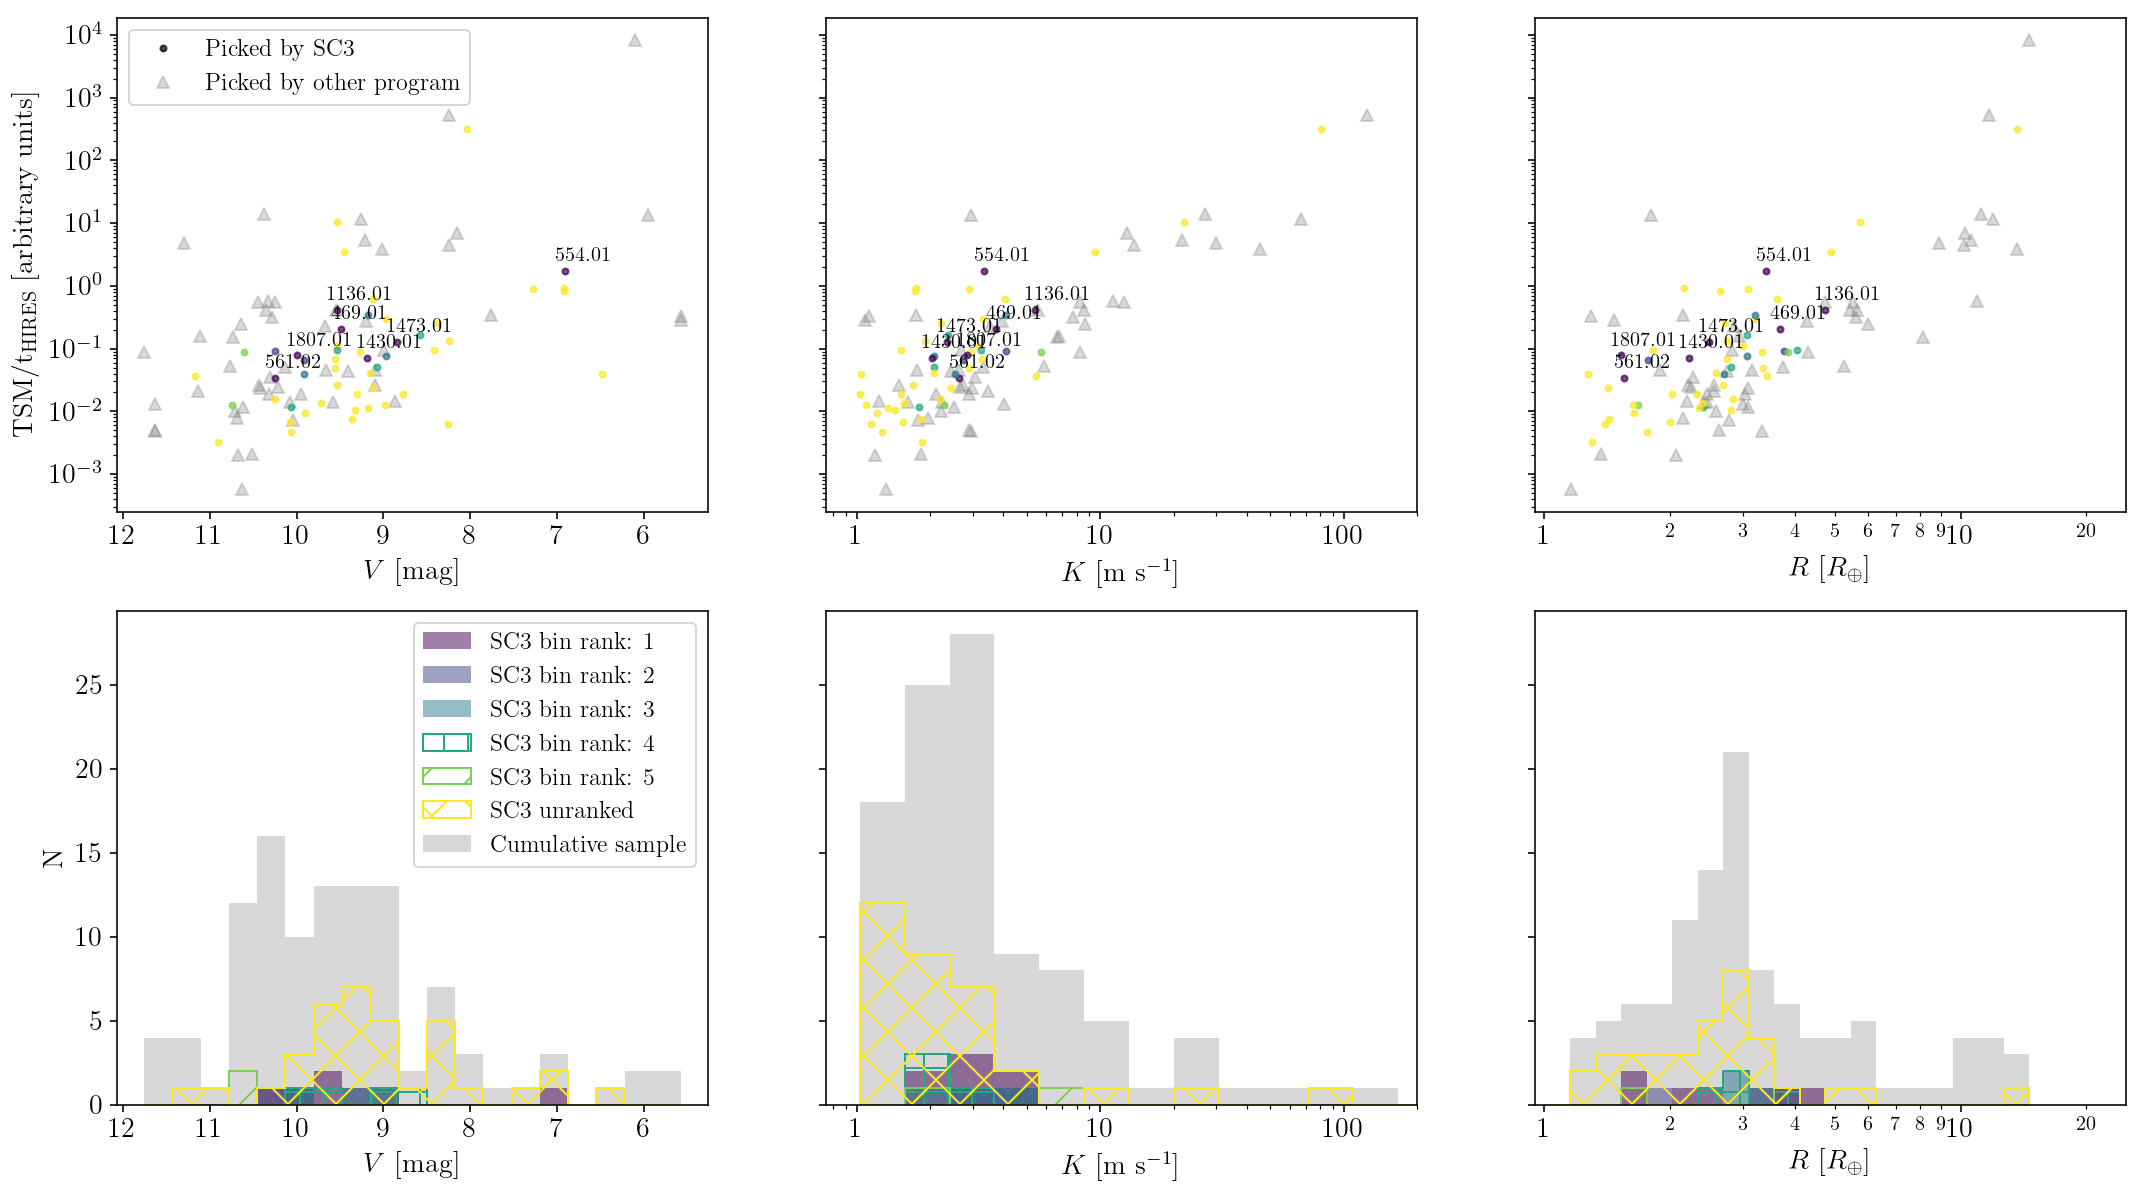

In [37]:
fig, ax = sc3_summary_plot(sc3_picks_df, tois_picked_df, annotate=True, annotate_up_to=1)
# fig.savefig('plots/sc3_summary_plot_annotation.pdf', bbox_inches='tight')
plt.show()

In [21]:
sc3_picks_df.sort_values('SC3_bin_rank')

,toi,tic,cps_name,tic_jump,toi_jump,evol,source,disp,photo_vetting,spec_vetting,ao_vetting,ra,dec,tmag,tmag_err,vmag,jmag,nobs,last_observed,rms,errvel,template,nobs_goal,tottime,remaining_nobs,remaining_time,n_comments,last_comment,rs,rs_err,r_s,m_s,teff,teff_err,t_eff,logg,logg_err,feh,ast_det_c,current_sectors,ast_det_t,total_sectors,color,spectral_type,vsini,prot,sval,logrhk,jitter,activity,ruwe,rp,rp_err,mp,k,kerr,ksig,epoch,epoch_err,period,period_err,duration,duration_err,b_est,circ_dur,circ_dur_err,max_circ_dur,a_to_R,depth,depth_err,teq,sinc,SNR,dist,prv,ra_J2000,dec_J2000,tks_comments,toi_comments,comment_list,npl,in_other_programs,in_SC1A,in_SC1B,in_SC1C,in_SC1D,in_SC1E,in_SC2A,in_SC2Bi,in_SC2Bii,in_SC2C,in_SC3,in_SC4,in_TOA,in_TOB,SC3_bin_rank,TSM,priority,t_HIRES,X
177,1136.01,142276270,T001136,142276270,1136,MS,qlp,CPC,passed,passed,-,192.1849,64.8553,8.936,0.006,9.534,8.363,14,75,35.31,1.53,True,100,5.95,86,13.660821,16,123,0.98,0.05,0.98,1.03,5729.00,131.1000,5767,4.470,0.080,0.03,0.0500,4,0.0500,4,0.677,G5,5.35,8.75,0.275,-4.590,4.47,505.43,1.05,4.72,0.24,19.98,5.39,0.31,17.62,1686.0723,0.0012,12.517810,0.000100,4.07,0.11,0.0746,3.50,0.92,4.08,23.44,2270.00,0.35,827.000000,77.667900,66.000000,84.54,True,12 48 44.4,+64 51 19,"clear field, Prot=7.5d",potential L1 in multi-planet system,"Needs Vetting Spectra, Needs Vetting Spectra, ...",3,6,0,1,0,0,1,0,0,1,1,1,0,0,1,1.0,112.062736,15.0,272.178116,0.411726
358,1473.01,352413427,6061,352413427,1473,MS,spoc,PC,passed,passed,-,15.5982,37.1855,8.297,0.006,8.844,7.711,17,86,NaN,NaN,True,100,5.15,83,8.284496,1,160,0.99,0.04,0.99,1.09,5958.00,121.2560,5958,4.482,0.076,-0.08,0.0532,1,0.0532,1,0.580,-,2.40,NaN,0.178,-4.869,2.86,563.55,1.01,2.49,0.46,6.77,2.35,0.33,7.06,1769.7844,0.0027,5.255294,0.001298,3.27,0.27,-1.6767,2.61,0.69,3.04,13.20,557.89,51.19,1061.120081,299.625751,8.702014,67.62,True,01 02 23.6,+37 11 07,"dT=6.3 sep=3.1'' S, dV=11.4 sep=7.3''",Level 1,Passes vetting. Cross correlation noisy. Syste...,1,6,0,1,0,0,1,1,0,1,0,1,0,0,1,1.0,97.545685,28.0,758.394211,0.128621
321,1430.01,293954617,235088,293954617,1430,MS,spoc,PC,passed,passed,-,300.6143,53.3768,8.388,0.006,9.190,7.646,7,141,NaN,NaN,True,100,5.15,93,11.603019,4,23,0.78,0.05,0.78,0.85,5064.00,119.1180,5064,4.579,0.085,0.01,0.0513,3,0.0513,3,0.948,-,0.61,NaN,0.406,-4.634,3.10,530.80,0.96,2.23,0.61,5.60,2.04,0.45,4.51,1713.0813,0.0021,7.434007,0.001097,2.76,0.25,0.3464,2.51,0.66,2.93,19.38,744.74,50.72,744.344144,72.546440,13.492878,41.17,False,20 02 27.4,+53 22 36,"clear field, DV looks good",TOI 1430 TFOP under investigation,Passes vetting. No secondary lines. HIRES Spec...,1,6,0,1,0,0,1,0,1,1,0,1,0,0,1,1.0,98.630155,44.0,1384.109339,0.071259
75,561.02,377064495,T000561,377064495,561,MS,spoc,CPC,passed,passed,-,148.1856,6.2164,9.495,0.017,10.252,8.879,42,75,4.58,1.38,True,100,9.66,58,16.036550,54,30,0.88,0.11,0.84,0.95,5391.00,185.0000,5440,4.525,0.289,-0.48,0.0504,1,0.0504,1,0.786,NaN,0.00,NaN,0.145,-5.116,2.07,441.46,1.13,1.55,1.52,3.04,2.63,0.22,11.81,1517.4981,0.0017,0.446547,0.000064,1.37,0.29,-8.7523,1.02,0.27,1.19,2.88,290.00,29.23,2103.695493,4628.630447,9.071973,85.80,True,09 52 44.5,+06 12 58,3 planets! Great system -- we have 17 RVs so ...,USP,Started observing 3-planet system before July ...,3,9,1,1,1,0,1,1,0,1,1,1,0,0,1,1.0,75.021337,10.0,2214.722087,0.033874
579,1807.01,180695581,HIP65469,180695581,1807,MS,spoc,CPC,passed,passed,-,201.2833,38.9225,9.036,0.006,10.000,8.103,0,-1,NaN,NaN,False,60,8.07,60,14.145929,1,13,0.74,0.05,0.74,0.73,4612.99,99.6652,4612,4.562,0.084,0.02,0.0504,2,0.0504,2,NaN,-,3.66,NaN,NaN,NaN,NaN,NaN,1.05,1.53,0.94,2.94,2.83,0.36,7.79,1899.3463,0.0012,0.549343,0.000043,1.00,0.16,0.5688,1.05,0.28,1.22,3.43,368.99,31.38,1611.268853,1592.916641,10.166403,42.58,False,13 25 08.0,+38 55 20,"dV=6.8 sep=42.9""NW, offset=2.0sig. USP (P=0.5d)",active star,"Spectroscopic vetting looks OK, but unclear if...",1,7,1,0,1,0,1,1,1,1,0,1,0,0,0,1.0,118.264533,38.0,1516.553944,0.077982
